In [3]:
import pandas as pd

path = r'../../../DataSet/zy bank/train_public.csv'
train_bank = pd.read_csv(path)
train_bank.columns

Index(['loan_id', 'user_id', 'total_loan', 'year_of_loan', 'interest',
       'monthly_payment', 'class', 'employer_type', 'industry', 'work_year',
       'house_exist', 'censor_status', 'issue_date', 'use', 'post_code',
       'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low',
       'scoring_high', 'known_outstanding_loan', 'known_dero',
       'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status',
       'app_type', 'earlies_credit_mon', 'title', 'policy_code', 'f0', 'f1',
       'f2', 'f3', 'f4', 'early_return', 'early_return_amount',
       'early_return_amount_3mon', 'isDefault'],
      dtype='object')

In [5]:
# feature engineering
import datetime
# date：issueDate 
train_bank['issue_date'] = pd.to_datetime(train_bank['issue_date'])
# extract
train_bank['issue_date_y'] = train_bank['issue_date'].dt.year
train_bank['issue_date_m'] = train_bank['issue_date'].dt.month
# get diff and transform it to days
base_time = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')   # 随机设置初始的基准时间
train_bank['issue_date_diff'] = train_bank['issue_date'].apply(lambda x: x-base_time).dt.days
# 
train_bank['earlies_credit_mon'] = train_bank['earlies_credit_mon'].map(lambda x:int(sorted(x.split('-'))[0]))
train_bank.head()


# work year
train_bank['work_year'].fillna('10+ years', inplace=True)

work_year_map = {'10+ years': 10, '2 years': 2, '< 1 year': 0, '3 years': 3, '1 year': 1,
     '5 years': 5, '4 years': 4, '6 years': 6, '8 years': 8, '7 years': 7, '9 years': 9}
train_bank['work_year']  = train_bank['work_year'].map(work_year_map)

train_bank['class'] = train_bank['class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

# na
train_bank = train_bank.fillna('9999')

# discrete num and cate

drop_list = ['isDefault','earlies_credit_mon','loan_id','user_id','issue_date']
num_feas = []
cate_feas = []

for col in train_bank.columns:
    if col not in drop_list:
        try:
            train_bank[col] = pd.to_numeric(train_bank[col]) # 转为数值
            num_feas.append(col)
        except:
            train_bank[col] = train_bank[col].astype('category')
            cate_feas.append(col)
            
print(cate_feas)
print(num_feas)

['employer_type', 'industry']
['total_loan', 'year_of_loan', 'interest', 'monthly_payment', 'class', 'work_year', 'house_exist', 'censor_status', 'use', 'post_code', 'region', 'debt_loan_ratio', 'del_in_18month', 'scoring_low', 'scoring_high', 'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup', 'recircle_b', 'recircle_u', 'initial_list_status', 'app_type', 'title', 'policy_code', 'f0', 'f1', 'f2', 'f3', 'f4', 'early_return', 'early_return_amount', 'early_return_amount_3mon', 'issue_date_y', 'issue_date_m', 'issue_date_diff']


In [8]:
# EDA
import toad
import sklearn
from sklearn.model_selection import train_test_split
toad.detector.detect(train_bank)

# 特征选择,根据相关性 缺失率、IV 等指标
train_selected, dropped = toad.selection.select(train_bank,target = 'isDefault', empty = 0.5, iv = 0.05, corr = 0.7, return_drop=True, exclude=['earlies_credit_mon','loan_id','user_id','issue_date'])
print(dropped)
print(train_selected.shape)

# 划分训练集 测试集
train_x, test_x, train_y, test_y = train_test_split(train_selected.drop(['loan_id','user_id','isDefault','issue_date','earlies_credit_mon'],axis=1), train_selected.isDefault,test_size=0.3, random_state=0)

{'empty': array([], dtype=float64), 'iv': array(['total_loan', 'monthly_payment', 'employer_type', 'industry',
       'work_year', 'house_exist', 'censor_status', 'use', 'post_code',
       'region', 'del_in_18month', 'scoring_high',
       'known_outstanding_loan', 'known_dero', 'pub_dero_bankrup',
       'recircle_b', 'recircle_u', 'initial_list_status', 'app_type',
       'policy_code', 'f1', 'f2', 'f3', 'f4', 'issue_date_y',
       'issue_date_m'], dtype=object), 'corr': array(['interest', 'early_return_amount_3mon'], dtype=object)}
(10000, 14)


In [9]:
# 特征的卡方分箱
combiner = toad.transform.Combiner()

# 训练数据并指定分箱方法
combiner.fit(pd.concat([train_x,train_y], axis=1), y='isDefault',method= 'chi',min_samples = 0.05,exclude=[])

# 以字典形式保存分箱结果
bins = combiner.export()

bins 

{'year_of_loan': [5],
 'class': [1, 2, 3, 4],
 'debt_loan_ratio': [9.155454545, 23.44090909],
 'scoring_low': [560.4545455, 621.8181818, 660.0, 690.9090909, 730.0, 775.0],
 'title': [3],
 'f0': [7.0, 11.0],
 'early_return': [1],
 'early_return_amount': [51, 2127],
 'issue_date_diff': [5875, 6057]}

<AxesSubplot:xlabel='scoring_low', ylabel='prop'>

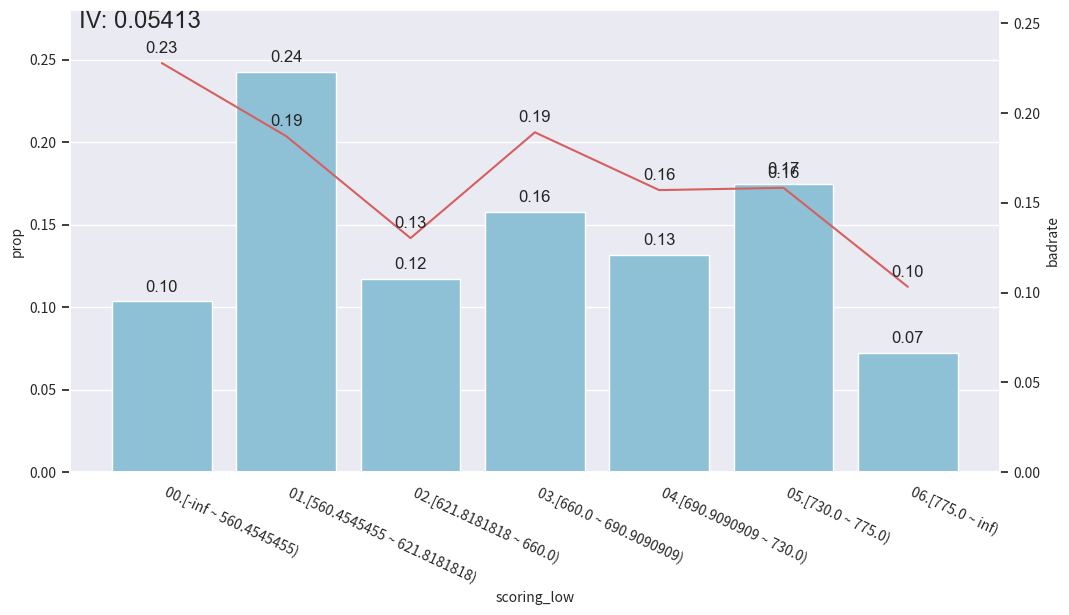

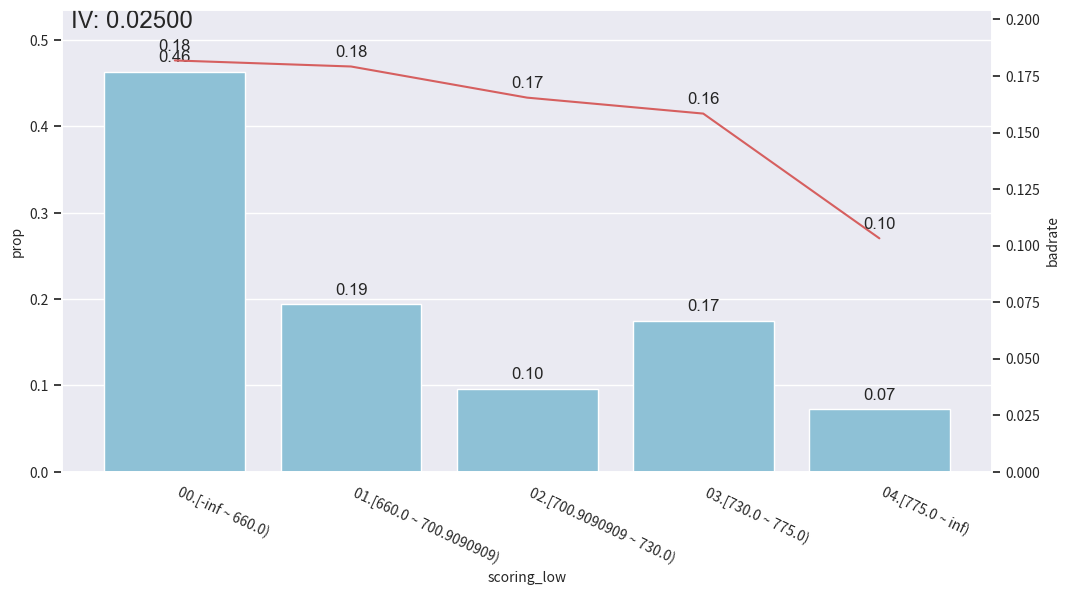

In [39]:
from toad.plot import badrate_plot, proportion_plot
# badrate_plot(temp_data, target = 'isDefault', x = 'type', by = adj_var)
# proportion_plot(temp_data[adj_var])
from toad.plot import  bin_plot,badrate_plot

adj_var = 'scoring_low'
data_ = pd.concat([train_x,train_y], axis=1)
data_['type'] = 'train'

#调整前原来的分箱 [560.4545455, 621.8181818, 660.0, 690.9090909, 730.0, 775.0], 保证单调性，更好解释
origin_bin = {adj_var: [560.4545455, 621.8181818, 660.0, 690.9090909, 730.0, 775.0]}
adj_bin = {adj_var: [ 660.0, 700.9090909, 730.0, 775.0]}

c1 = toad.transform.Combiner()
c1.set_rules(origin_bin)
temp_re1 = c1.transform(data_[[adj_var,'isDefault','type']], labels=True)


c2 = toad.transform.Combiner()
c2.set_rules(adj_bin)
temp_re2 = c2.transform(data_[[adj_var,'isDefault','type']], labels=True)

bin_plot(temp_re1, target = 'isDefault',x=adj_var)
bin_plot(temp_re2, target = 'isDefault',x=adj_var)

In [35]:
c2

In [11]:
# 更新调整后的分箱
combiner.set_rules(adj_bin)
combiner.export()


{'year_of_loan': [5],
 'class': [1, 2, 3, 4],
 'debt_loan_ratio': [9.155454545, 23.44090909],
 'scoring_low': [660.0, 700.9090909, 730.0, 775.0],
 'title': [3],
 'f0': [7.0, 11.0],
 'early_return': [1],
 'early_return_amount': [51, 2127],
 'issue_date_diff': [5875, 6057]}

In [14]:
#通过WOE编码给各个分箱不同的权重，提升LR模型的非线性。
#计算WOE，仅在训练集计算WOE，不然会标签泄露
transer = toad.transform.WOETransformer()
binned_data = combiner.transform(pd.concat([train_x,train_y], axis=1))

#对WOE的值进行转化，映射到原数据集上。对训练集用fit_transform,测试集用transform.
data_tr_woe = transer.fit_transform(binned_data, binned_data['isDefault'],  exclude=['isDefault'])
data_tr_woe.head()

## test woe

# 先分箱
binned_data = combiner.transform(test_x)
#对WOE的值进行转化，映射到原数据集上。测试集用transform.
data_test_woe = transer.transform(binned_data)
data_test_woe.head()

,year_of_loan,class,debt_loan_ratio,scoring_low,title,f0,early_return,early_return_amount,issue_date_diff
9394,-0.206792,-0.385727,-0.037954,0.081927,-0.111108,0.122153,0.863672,-2.021976,-0.090276
898,0.515980,0.362590,0.342059,0.063874,0.097018,-0.107512,0.863672,1.218112,-0.090276
2398,-0.206792,-0.385727,-0.432534,-0.032779,-0.111108,-0.107512,-2.224164,-2.514119,0.393667
5906,-0.206792,0.362590,-0.037954,0.081927,0.097018,-0.107512,0.863672,1.218112,0.007097
2343,-0.206792,0.195590,-0.037954,0.081927,-0.111108,0.122153,0.863672,1.218112,-0.090276


train  {'AUC': 0.8735618102662752, 'KS': 0.6574263440315886, 'f1': 0.5712788259958071, 'P': 0.4150799695354151, 'R': 0.9159663865546218}
test  {'AUC': 0.8683560270593251, 'KS': 0.6343495818199911, 'f1': 0.5471236230110159, 'P': 0.39176161262050835, 'R': 0.9066937119675457}


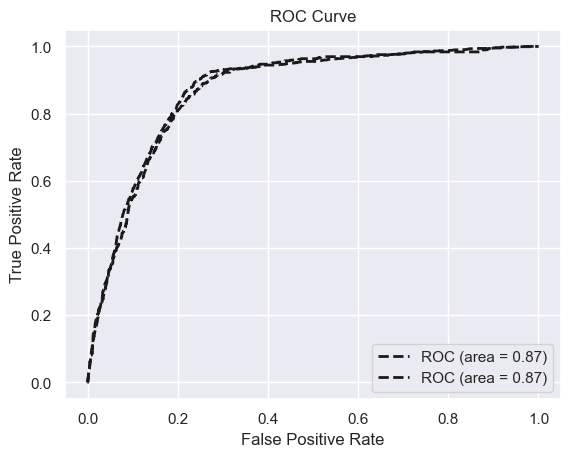

In [25]:
# 训练LR模型
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt


def model_metrics(model, x, y):
    """ 评估 """
    yhat = model.predict(x)
    yprob = model.predict_proba(x)[:,1]
    fpr,tpr,_ = roc_curve(y, yprob,pos_label=1)
    metrics = {'AUC':auc(fpr, tpr),'KS':max(tpr-fpr),
               'f1':f1_score(y,yhat),'P':precision_score(y,yhat),'R':recall_score(y,yhat)}
    
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)

    plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
    plt.title('ROC Curve')
    plt.legend(loc="lower right")


    return metrics

lr = LogisticRegression(class_weight='balanced')
lr.fit(data_tr_woe.drop(['isDefault'],axis=1), data_tr_woe['isDefault'])

print('train ',model_metrics(lr,data_tr_woe.drop(['isDefault'],axis=1), data_tr_woe['isDefault']))
print('test ',model_metrics(lr,data_test_woe,test_y))

In [26]:

train_prob = lr.predict_proba(data_tr_woe.drop(['isDefault'],axis=1))[:,1]
test_prob = lr.predict_proba(data_test_woe)[:,1]


# Group the predicted scores in bins with same number of samples in each (i.e. "quantile" binning)
toad.metrics.KS_bucket(train_prob, data_tr_woe['isDefault'], bucket=10, method = 'quantile')

,min,max,bads,goods,total,bad_rate,good_rate,odds,bad_prop,good_prop,...,cum_bad_rate_rev,cum_bads_prop,cum_bads_prop_rev,cum_goods_prop,cum_goods_prop_rev,cum_total_prop,cum_total_prop_rev,ks,lift,cum_lift
0,0.013047,0.044162,7,692,699,0.010014,0.989986,0.010116,0.005882,0.119105,...,0.170000,0.005882,1.000000,0.119105,1.000000,0.099857,1.000000,0.113223,0.058908,1.000000
1,0.044321,0.064573,11,685,696,0.015805,0.984195,0.016058,0.009244,0.117900,...,0.187748,0.015126,0.994118,0.237005,0.880895,0.199286,0.900143,0.221879,0.092968,1.104400
2,0.064594,0.083390,11,683,694,0.015850,0.984150,0.016105,0.009244,0.117556,...,0.209099,0.024370,0.984874,0.354561,0.762995,0.298429,0.800714,0.330191,0.093236,1.229994
3,0.083452,0.102911,19,692,711,0.026723,0.973277,0.027457,0.015966,0.119105,...,0.236408,0.040336,0.975630,0.473666,0.645439,0.400000,0.701571,0.433330,0.157194,1.390636
4,0.102932,0.131053,18,680,698,0.025788,0.974212,0.026471,0.015126,0.117040,...,0.271905,0.055462,0.959664,0.590706,0.526334,0.499714,0.600000,0.535243,0.151694,1.599440
5,0.131263,0.200873,19,683,702,0.027066,0.972934,0.027818,0.015966,0.117556,...,0.320959,0.071429,0.944538,0.708262,0.409294,0.600000,0.500286,0.636833,0.159209,1.887997
6,0.201175,0.683784,136,553,689,0.197388,0.802612,0.245931,0.114286,0.095181,...,0.394643,0.185714,0.928571,0.803442,0.291738,0.698429,0.400000,0.617728,1.161103,2.321429
7,0.683846,0.766938,238,473,711,0.334740,0.665260,0.503171,0.200000,0.081411,...,0.459024,0.385714,0.814286,0.884854,0.196558,0.800000,0.301571,0.499139,1.969058,2.700142
8,0.767307,0.822001,324,372,696,0.465517,0.534483,0.870968,0.272269,0.064028,...,0.522143,0.657983,0.614286,0.948881,0.115146,0.899429,0.200000,0.290898,2.738337,3.071429
9,0.822042,0.926914,407,297,704,0.578125,0.421875,1.370370,0.342017,0.051119,...,0.578125,1.000000,0.342017,1.000000,0.051119,1.000000,0.100571,-0.000000,3.400735,3.400735
